In [1]:
import pandas as pd
import plotly
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import holidays

from neuralprophet import NeuralProphet
from prophet import Prophet
from prophet.serialize import model_to_json
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

import sys
import os

backend_path = os.path.abspath('../backend')
sys.path.append(backend_path)
from get_metrics import get_metrics

# Количество предсказанных дней
pred_days_forecast = 180

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


In [2]:
# Чтение DataFrame df в файл data/df.csv
df = pd.read_csv('../data/df.csv')

# Чтение DataFrame df_train в файл data/df_train.csv
df_train = pd.read_csv('../data/df_train.csv')

# Чтение DataFrame df_test в файл data/df_test.csv
df_test = pd.read_csv('../data/df_test.csv')

In [3]:
# Преобразование столбца ds в формат datetime
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d', dayfirst=True)
df_train['ds'] = pd.to_datetime(df_train['ds'], format='%Y-%m-%d', dayfirst=True)
df_test['ds'] = pd.to_datetime(df_test['ds'], format='%Y-%m-%d', dayfirst=True)

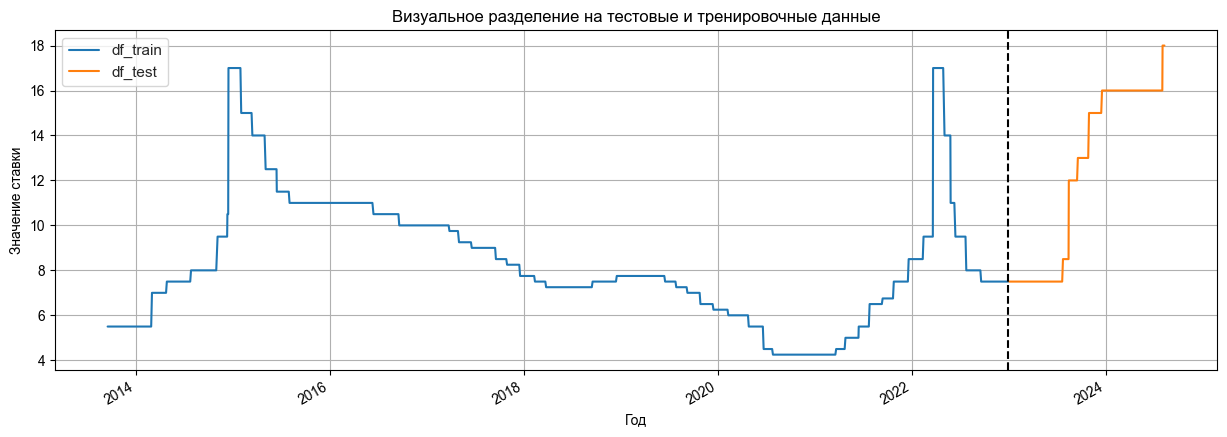

In [4]:
# Отображаем график с разделением train, test для наглядности
fig, ax = plt.subplots(figsize = (10, 5))

sns.set_theme(style="whitegrid", palette="Accent")

fig.set_figheight(5)
fig.set_figwidth(15)
df_train.set_index('ds').plot(ax=ax, label= 'train', title='Визуальное разделение на тестовые и тренировочные данные')
df_test.set_index('ds').plot(ax=ax, label='test')
ax.axvline(df_train['ds'][-1:].values, ls='--', color='black')
ax.legend(['df_train', 'df_test'])
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

# Baseline Prophet on df_train для проверки модели

In [5]:
# Обучение модели на train
model_baseline = Prophet()
model_baseline.fit(df_train)

00:37:48 - cmdstanpy - INFO - Chain [1] start processing
00:37:48 - cmdstanpy - INFO - Chain [1] done processing


In [6]:
# Период, который надо отрезать и предсказать (проверка модели)
pred_days = int(df.shape[0]*0.15)

In [7]:
# Создание df с прогнозом
future = model_baseline.make_future_dataframe(periods=pred_days, freq='D')
forecast = model_baseline.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2713,2024-02-06,14.707704,12.663963,16.993296
2714,2024-02-07,14.719890,12.613329,16.660230
2715,2024-02-08,14.698294,12.508009,16.983024
2716,2024-02-09,14.695406,12.575147,16.949617
2717,2024-02-10,15.212399,13.164355,17.349480


WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',



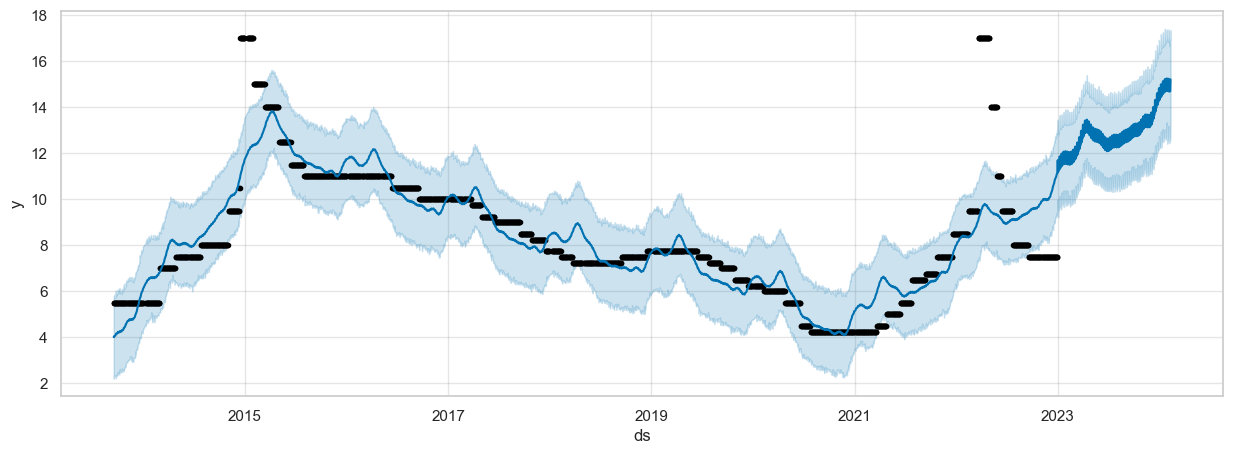

In [8]:
# Смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model_baseline.plot(forecast,ax=ax)
plt.show()

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarn

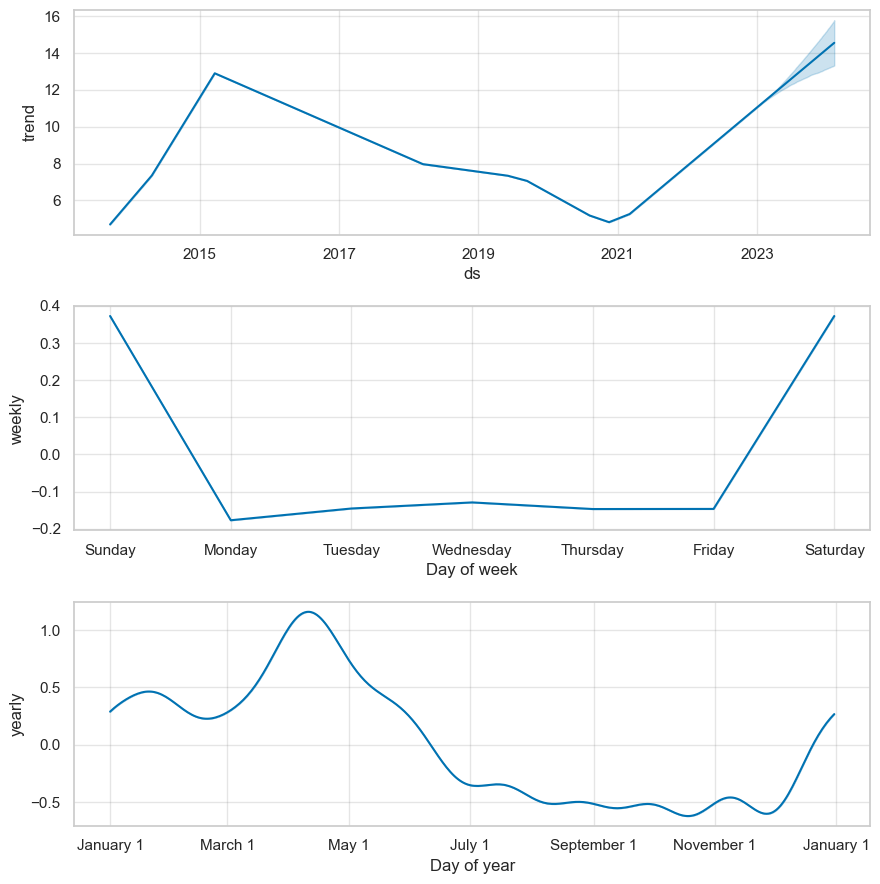

In [9]:
# Смотрим тренд, годовые и сезонные признаки
fig = model_baseline.plot_components(forecast)
plt.show()

## Сравнение фактов и прогнозов

In [10]:
# Создание df с прогнозом
df_test_forecast = model_baseline.predict(df_test)
df_test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
402,2024-08-05,15.418951,12.544330,18.237663
403,2024-08-06,15.453464,12.594267,18.126664
404,2024-08-07,15.473647,12.734026,18.029889
405,2024-08-08,15.460609,12.492708,18.271914
406,2024-08-09,15.466682,12.673796,18.158692


WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',



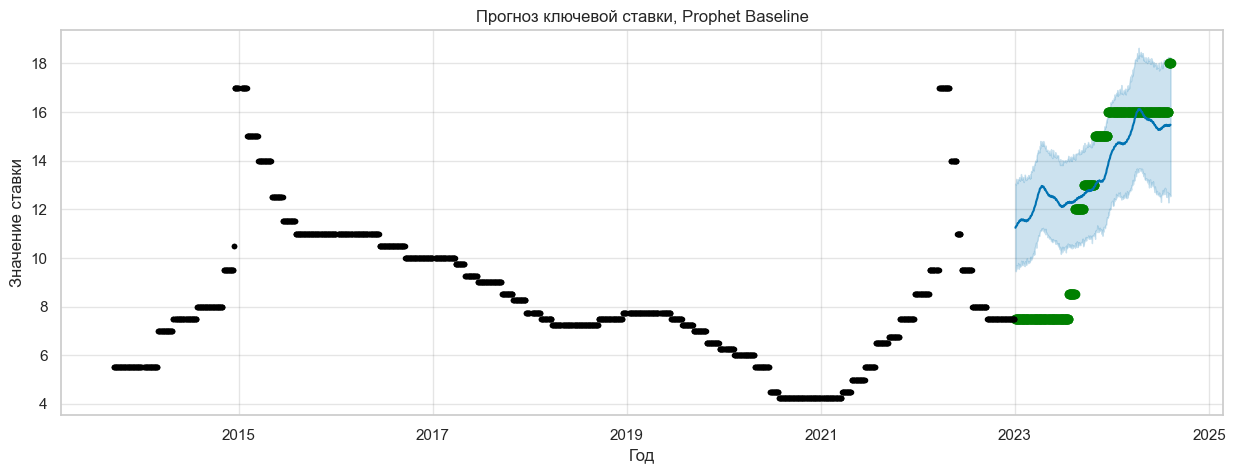

In [11]:
# Смотрим совпадение фактического курса с предсказанным курсом prophet baseline обученным на train
fig, ax = plt.subplots(figsize= (10, 5))

fig.set_figheight(5)
fig.set_figwidth(15)
predict = model_baseline.predict(df_test)
fig = model_baseline.plot(predict, ax=ax)
ax.scatter(df_test.ds, df_test['y'], color = 'g')
ax.set_title('Прогноз ключевой ставки, Prophet Baseline')
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

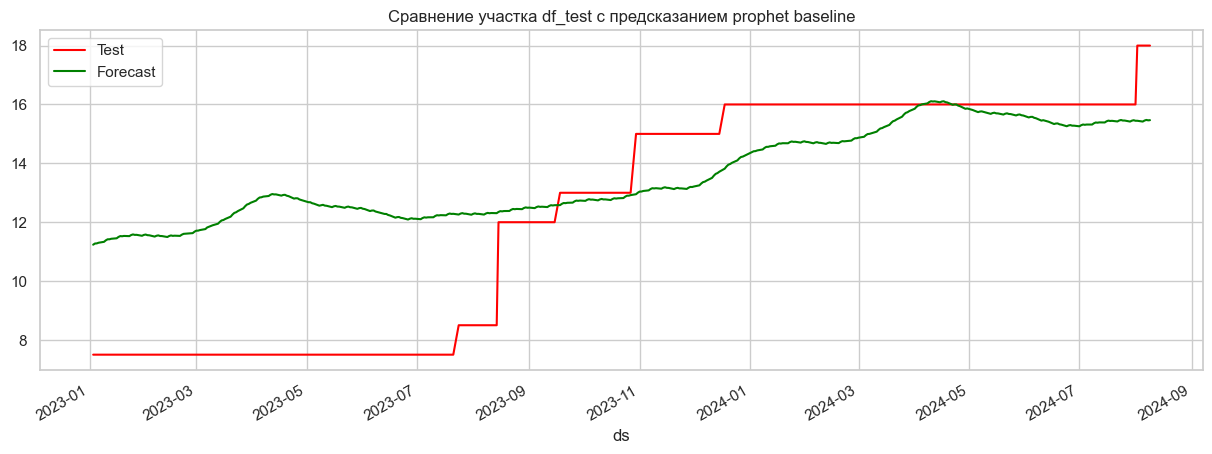

In [12]:
# Сравнение участка df_test с предсказанием prophet baseline
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet baseline')
plt.show()

In [13]:
# Просмотр метрик модели обученной на train
metrics = get_metrics(y_test=df_test['y'], y_pred=df_test_forecast['yhat'], name='Prophet_baseline')
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,2.269669,0.263704,8.751311,2.958261


Из приведенного выше графика мы видим, что существует разрыв в прогнозах и фактических данных. Поэтому нам нужно оптимизировать модель, добавив другие параметры, напрмиер, такие как праздники

# Prophet with holidays

In [14]:
# Создаем df праздников в РФ начиная с 2013 по сегодня
holiday = pd.DataFrame([])
for date, name in sorted(holidays.Russia(years=[2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024]).items()):
    new_row = pd.DataFrame({'ds': date, 'holiday': "RU-Holidays"}, index=[0])
    holiday = pd.concat([holiday, new_row], ignore_index=True)  

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

WARNING - (py.warnings._showwarnmsg) - C:\Users\myxa-\AppData\Local\Temp\ipykernel_17560\3236026523.py:7: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')



In [15]:
# Тренировка модели с праздниками
model_with_holidays = Prophet(holidays=holiday)
model_with_holidays.fit(df_train)

00:37:51 - cmdstanpy - INFO - Chain [1] start processing
00:37:52 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
# Создание df с прогнозом
future = model_with_holidays.make_future_dataframe(periods=pred_days, freq='D')
forecast = model_with_holidays.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2713,2024-02-06,14.626459,12.556218,16.664716
2714,2024-02-07,14.640113,12.521094,16.898567
2715,2024-02-08,14.618213,12.495930,16.812200
2716,2024-02-09,14.616992,12.328925,16.818477
2717,2024-02-10,15.164733,13.045439,17.500715


WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',



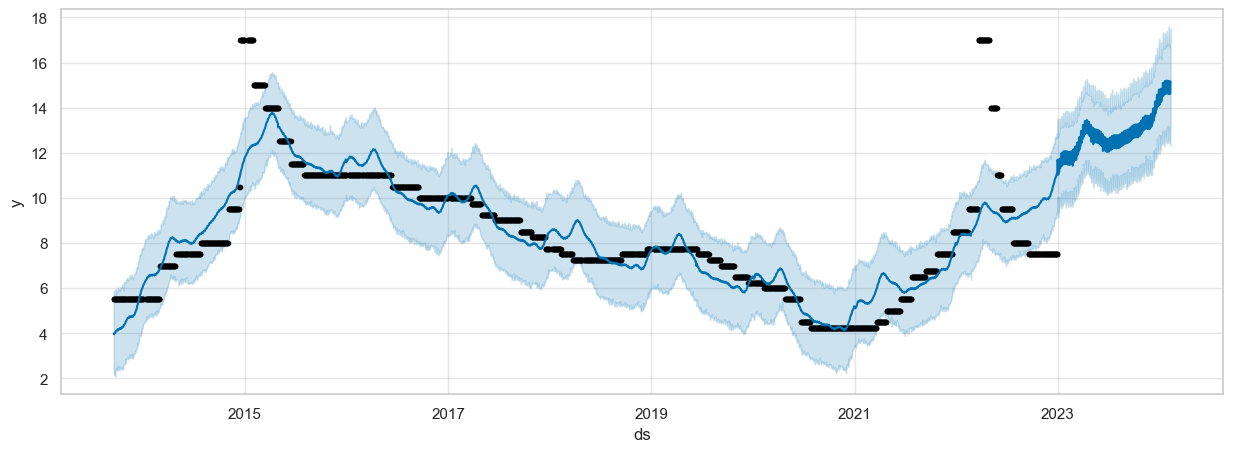

In [17]:
# Смотрим график прогноза с праздниками
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model_with_holidays.plot(forecast,ax=ax)
plt.show()

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarn

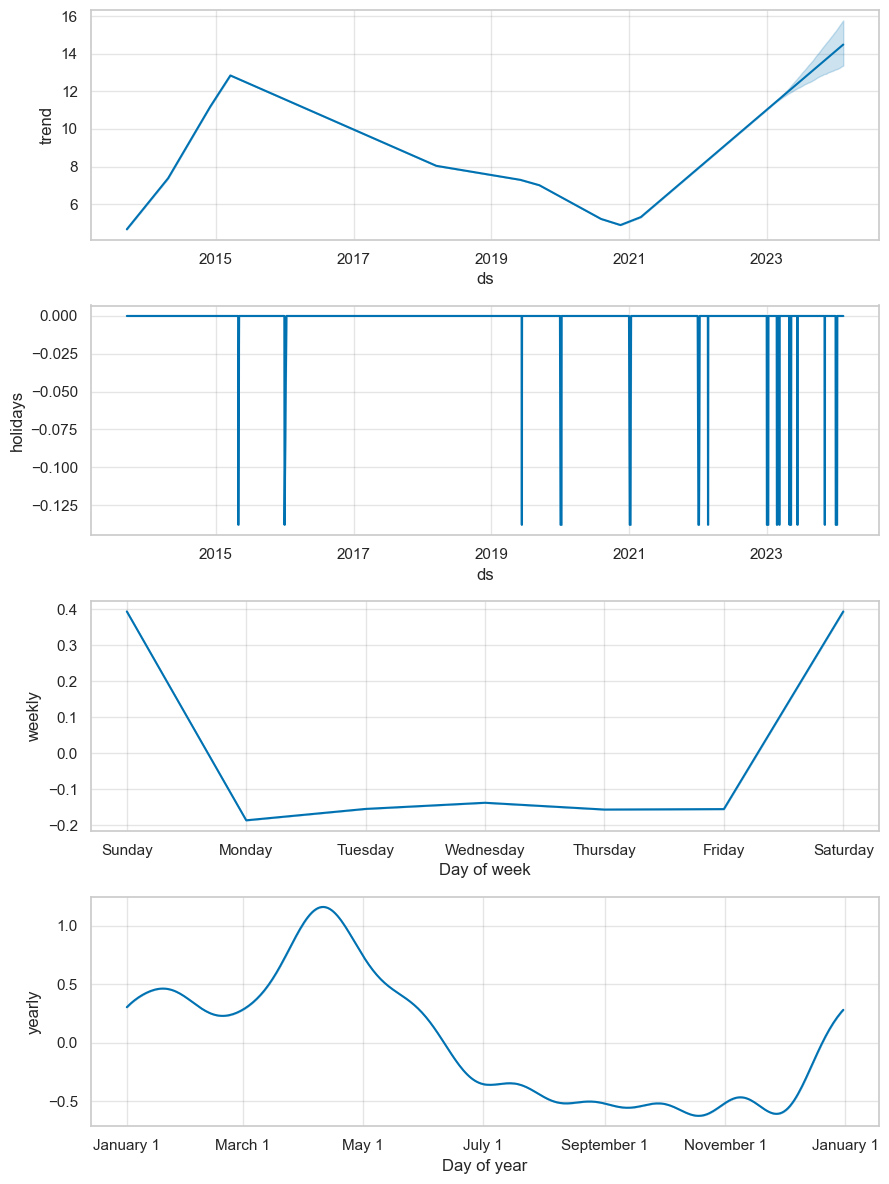

In [18]:
# Смотрим тренд, годовые и сезонные признаки обученной модели с праздниками
fig = model_with_holidays.plot_components(forecast)
plt.show()

## Сравнение фактов и прогнозов

In [19]:
# Создание df с прогнозом
df_test_forecast_holiday = model_with_holidays.predict(df_test)
df_test_forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
402,2024-08-05,15.321079,12.554047,18.030098
403,2024-08-06,15.355615,12.805036,17.860444
404,2024-08-07,15.376501,12.571077,18.179739
405,2024-08-08,15.362357,12.390772,18.087027
406,2024-08-09,15.369276,12.629600,18.000543


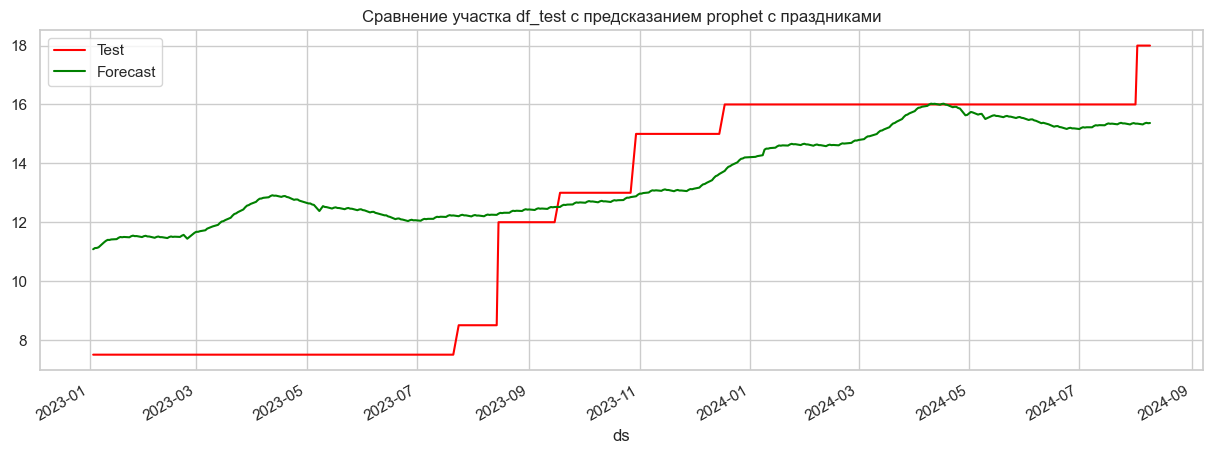

In [20]:
# Сравнение участка df_test с предсказанием prophet_with_holidays
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_holiday.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet с праздниками')
plt.show()

In [21]:
# Сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_holiday['yhat'], name='Prophet_with_holidays')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,2.269669,0.263704,8.751311,2.958261
0,Prophet_with_holidays,2.290373,0.263727,8.668202,2.944181


Из метрик и графиков видим, что модель с праздниками показывает результаты немного изменились.

# Тюнинг тест модели

In [22]:
# Создание сетки параметров и подсчёт количества вариаций обучения
params_grid = {
    'changepoint_prior_scale': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.3, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1, 10], 
    'holidays_prior_scale': [0.01, 0.1, 1, 10],
    'seasonality_mode': ('multiplicative','additive')
}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt + 1

print('Количество моделей для обучения по сетке:', cnt)

Количество моделей для обучения по сетке: 672


In [23]:
"""Обучение тестовой модели по сетке параметров на df_train"""
# Создаем пустой DataFrame для сохранения метрик и параметров
model_grid_metrics = pd.DataFrame()
model_grid_parameters = pd.DataFrame(columns = ['Parameters'])

# Проходимся по сетке гиперпараметров
for p in tqdm(grid):
    
    # Обучаем Prophet по сетке гиперпараметров
    model_grid = Prophet(
        changepoint_prior_scale = p['changepoint_prior_scale'],
        seasonality_prior_scale = p['seasonality_prior_scale'],
        holidays_prior_scale = p['holidays_prior_scale'],
        seasonality_mode = p['seasonality_mode'],
        #changepoint_range = p['changepoint_range'],
        #holidays=holiday,
    )

    # Добавляем праздники в модель
    #model_grid.add_country_holidays(country_name='RU')

    # Обучаем модель
    model_grid.fit(df_train)

    # Создаем фрейм данных для предсказаний
    model_grid_future = model_grid.make_future_dataframe(periods=pred_days, freq='D', include_history=False)

    # Делаем предсказания
    model_grid_forecast = model_grid.predict(model_grid_future)

    # Вычисляем метрики и добавляем новую строку в df
    model_grid_metrics = pd.concat([model_grid_metrics, get_metrics(y_test=df_test['y'], y_pred=model_grid_forecast['yhat'], name='Prophet_with_grid ')])
    model_grid_parameters = pd.concat([model_grid_parameters, pd.DataFrame({'Parameters': [p]})], ignore_index=True)


  0%|          | 0/672 [00:00<?, ?it/s]00:37:54 - cmdstanpy - INFO - Chain [1] start processing
00:37:54 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 1/672 [00:00<06:11,  1.80it/s]00:37:55 - cmdstanpy - INFO - Chain [1] start processing
00:37:55 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 2/672 [00:01<06:06,  1.83it/s]00:37:55 - cmdstanpy - INFO - Chain [1] start processing
00:37:55 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 3/672 [00:01<05:57,  1.87it/s]00:37:56 - cmdstanpy - INFO - Chain [1] start processing
00:37:56 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 4/672 [00:02<06:10,  1.80it/s]00:37:56 - cmdstanpy - INFO - Chain [1] start processing
00:37:56 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 5/672 [00:02<06:03,  1.83it/s]00:37:57 - cmdstanpy - INFO - Chain [1] start processing
00:37:57 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 6/672 [00:03<05:57,  1.86it/s]0

In [24]:
# Сброс индексов для будущего объединения с df параметров сетки
model_grid_metrics = model_grid_metrics.reset_index(drop=True)

In [25]:
# Объединение DataFrame по столбцам
metrics_parameters_with_grid = pd.concat([model_grid_metrics, model_grid_parameters], axis=1)
metrics_parameters_with_grid

,model,MAE,MAPE_%,MSE,RMSE,Parameters
0,Prophet_with_grid,5.384461,0.360206,46.040370,6.785305,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
1,Prophet_with_grid,5.668780,0.382974,50.096631,7.077897,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
2,Prophet_with_grid,5.659705,0.381612,50.161183,7.082456,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
3,Prophet_with_grid,5.545260,0.372865,48.437657,6.959717,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
4,Prophet_with_grid,5.354348,0.358038,45.641024,6.755814,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
...,...,...,...,...,...,...
667,Prophet_with_grid,15.857254,1.436747,552.210540,23.499160,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
668,Prophet_with_grid,3.104536,0.321999,12.216803,3.495254,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
669,Prophet_with_grid,3.137236,0.328581,12.748787,3.570544,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
670,Prophet_with_grid,3.150530,0.329337,12.842323,3.583619,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."


In [26]:
# Сортировка по метрике
metrics_parameters_with_grid = metrics_parameters_with_grid.sort_values(by=['MAE'])
metrics_parameters_with_grid = metrics_parameters_with_grid.reset_index(drop=True)
metrics_parameters_with_grid.head()

,model,MAE,MAPE_%,MSE,RMSE,Parameters
0,Prophet_with_grid,3.042272,0.315000,11.668407,3.415905,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
1,Prophet_with_grid,3.042272,0.315000,11.668407,3.415905,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
2,Prophet_with_grid,3.042272,0.315000,11.668407,3.415905,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
3,Prophet_with_grid,3.042272,0.315000,11.668407,3.415905,"{'changepoint_prior_scale': 0.05, 'holidays_pr..."
4,Prophet_with_grid,3.054692,0.315378,11.745718,3.427203,"{'changepoint_prior_scale': 0.04, 'holidays_pr..."


## Лучшие параметры после обучения по сетке

In [27]:
# Сохранение в переменную лучших параметров после обучения по сетке
best_params = metrics_parameters_with_grid['Parameters'][0]

# Просмотр лучших параметров
best_params

{'changepoint_prior_scale': 0.05,
 'holidays_prior_scale': 10,
 'seasonality_mode': 'additive',
 'seasonality_prior_scale': 10}

In [28]:
# Обучение модели на лучших параметрах
final_test_model = Prophet(**best_params)
final_test_model.fit(df_train)

00:49:50 - cmdstanpy - INFO - Chain [1] start processing
00:49:50 - cmdstanpy - INFO - Chain [1] done processing


In [29]:
# Создание df с прогнозом
future = final_test_model.make_future_dataframe(periods=pred_days, freq='D')
forecast = final_test_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2713,2024-02-06,14.707704,12.548303,16.909414
2714,2024-02-07,14.719890,12.629763,16.982992
2715,2024-02-08,14.698294,12.786266,16.919459
2716,2024-02-09,14.695406,12.535344,16.910562
2717,2024-02-10,15.212399,13.135914,17.363642


WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarn

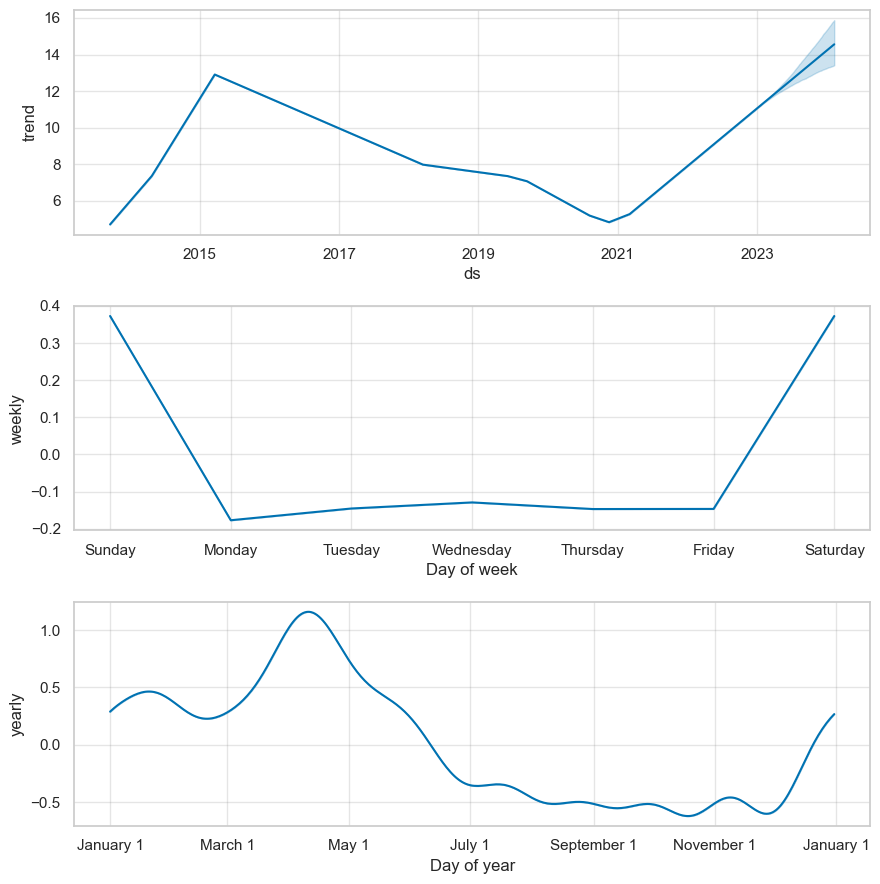

In [30]:
# Смотрим тренд, годовые и сезонные признаки
fig = final_test_model.plot_components(forecast)

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',



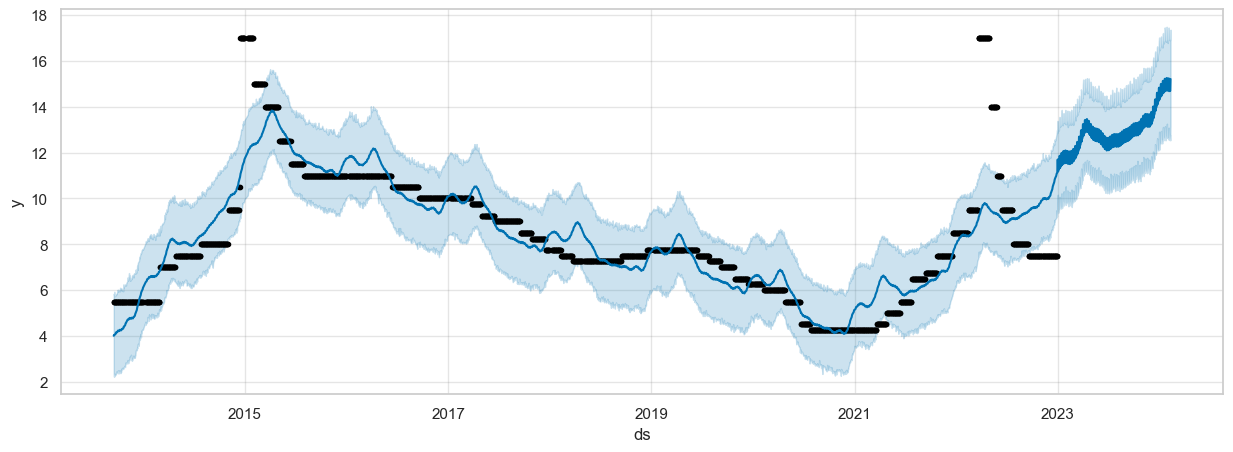

In [31]:
# Смотрим график прогноза после обучния на лучших параметрах
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = final_test_model.plot(forecast,ax=ax)
plt.show()

## Сравнение фактов и прогнозов

In [32]:
# Создание df с прогнозом
df_test_forecast_final = final_test_model.predict(df_test)
df_test_forecast_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
402,2024-08-05,15.418951,12.645564,18.163653
403,2024-08-06,15.453464,12.713504,18.280115
404,2024-08-07,15.473647,12.922156,18.174481
405,2024-08-08,15.460609,12.689372,18.237995
406,2024-08-09,15.466682,12.689837,18.257246


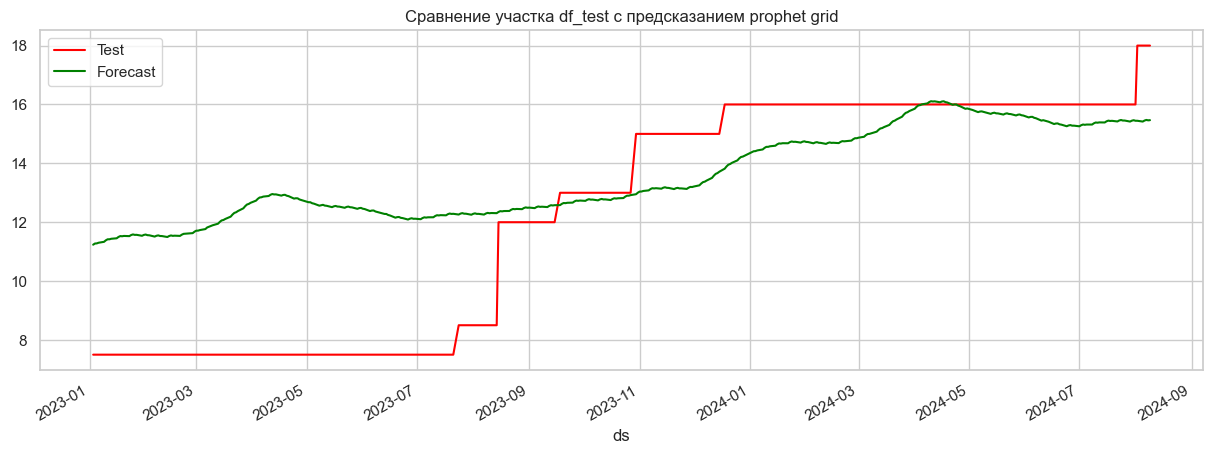

In [33]:
# Сравнение участка df_test с предсказанием prophet grid
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_final.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet grid')
plt.show()

In [34]:
# Сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_final['yhat'], name='Prophet_with_grid')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,2.269669,0.263704,8.751311,2.958261
0,Prophet_with_holidays,2.290373,0.263727,8.668202,2.944181
0,Prophet_with_grid,2.269669,0.263704,8.751311,2.958261


In [35]:
# Сохранение модели в JSON файл
with open('../models/final_test_model.json', 'w') as fout:
    fout.write(model_to_json(final_test_model))

# Baseline NeuralProphet on df_train для проверки модели

In [36]:
# Обучение модели на df
NeuralProphet_bl = NeuralProphet()
NeuralProphet_bl.set_plotting_backend("plotly-static")
metricsnp = NeuralProphet_bl.fit(df_train)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.231% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as B
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batc

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (37) is too small than the required number                     for the learning rate finder (234). The results might not be optimal.
WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 7. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.

Finding best initial lr: 100%|██████████| 234/234 [00:01<00:00, 136.64it/s]


Training: |          | 0/? [00:24<?, ?it/s, v_num=23, train_loss=0.023, reg_loss=0.000, MAE=0.801, RMSE=1.460, Loss=0.0235, RegLoss=0.000] 


In [37]:
# Создание df с прогнозом
future_np_bl = NeuralProphet_bl.make_future_dataframe(df_train, periods = pred_days, n_historic_predictions = True)
forecast_np_bl = NeuralProphet_bl.predict(df_test)
forecast_np_bl.tail()

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.231% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be remov

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 335.84it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,trend,season_yearly,season_weekly
402,2024-08-05,18.0,13.159702,12.478594,-0.234586,0.915694
403,2024-08-06,18.0,13.182174,12.484834,-0.239975,0.937315
404,2024-08-07,18.0,13.201012,12.491073,-0.245303,0.955242
405,2024-08-08,18.0,13.207108,12.497310,-0.250537,0.960337
406,2024-08-09,18.0,13.178123,12.503549,-0.255678,0.930252


WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\plot_forecast_matplotlib.py:300: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst["ds"].dt.to_pydatetime()



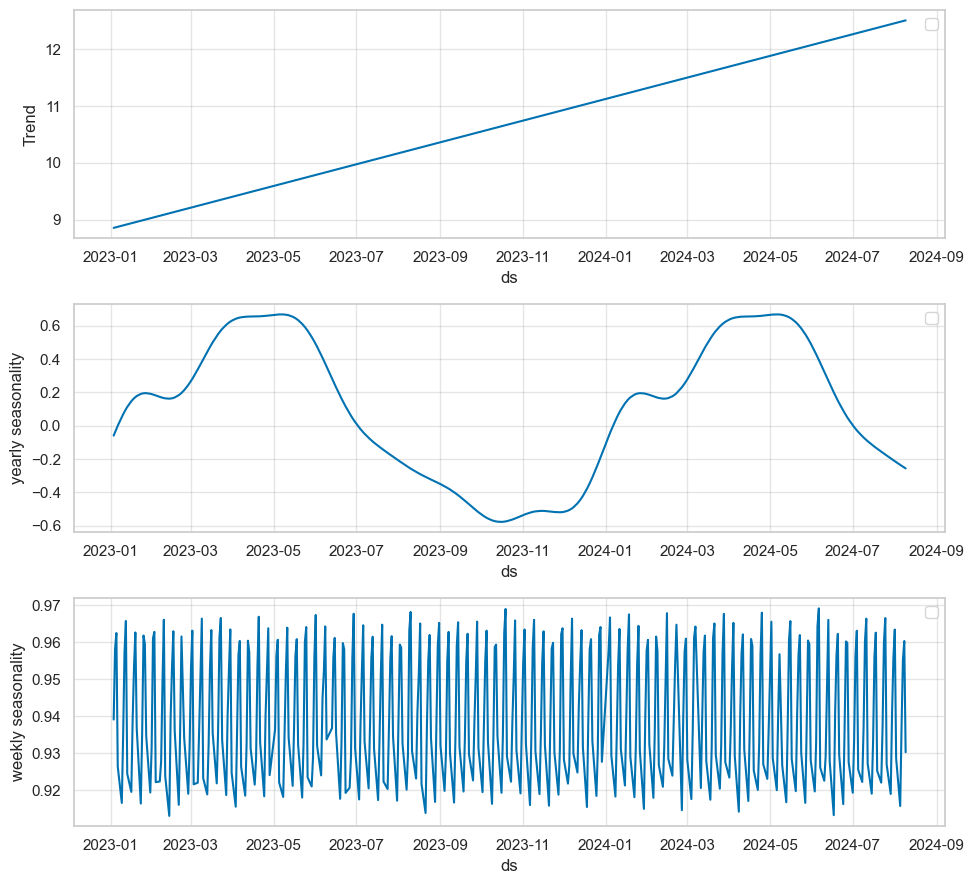

In [38]:
# Смотрим тренд, годовые и сезонные признаки
NeuralProphet_bl.plot_components(forecast_np_bl, plotting_backend="matplotlib")

In [39]:
# Смотрим график прогноза после обучения
fig = NeuralProphet_bl.plot(forecast_np_bl, ax=ax, plotting_backend="matplotlib")

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\plot_forecast_matplotlib.py:84: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ds = fcst["ds"].dt.to_pydatetime()



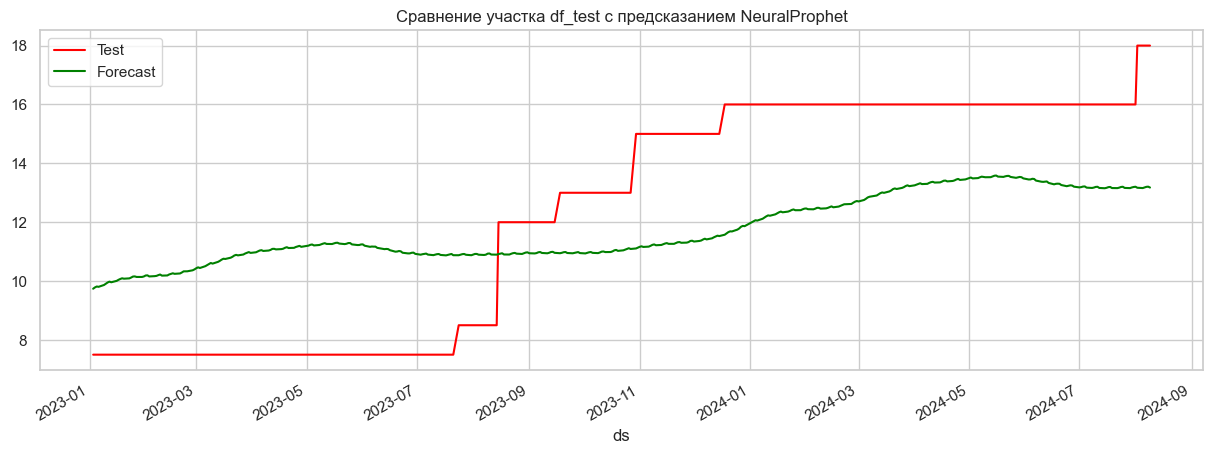

In [40]:
# Сравнение участка df_test с предсказанием prophet grid
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
forecast_np_bl.plot(kind='line',x='ds',y='yhat1', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием NeuralProphet')
plt.show()

In [41]:
# Сравниваем метрики после добавления NeuralProphet
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=forecast_np_bl['yhat1'], name='NeuralProphet')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,2.269669,0.263704,8.751311,2.958261
0,Prophet_with_holidays,2.290373,0.263727,8.668202,2.944181
0,Prophet_with_grid,2.269669,0.263704,8.751311,2.958261
0,NeuralProphet,2.976988,0.274275,9.464630,3.076464


# Обучение и прогнозирование курса ставки рефинансирования ЦБ РФ на полных данных

# Prophet baseline on df

In [42]:
# Обучение модели на df
prophet_bl = Prophet()
prophet_bl.fit(df)

00:50:22 - cmdstanpy - INFO - Chain [1] start processing
00:50:22 - cmdstanpy - INFO - Chain [1] done processing


In [43]:
# Создание df с прогнозом
future_bl = prophet_bl.make_future_dataframe(periods=pred_days_forecast, freq='D')
forecast_bl = prophet_bl.predict(future_bl)
forecast_bl[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2893,2025-02-01,18.001094,15.999104,20.247460
2894,2025-02-02,17.998859,15.808186,20.030172
2895,2025-02-03,17.233312,15.173833,19.338495
2896,2025-02-04,17.255561,15.066435,19.484480
2897,2025-02-05,17.268372,15.166586,19.446916


WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',



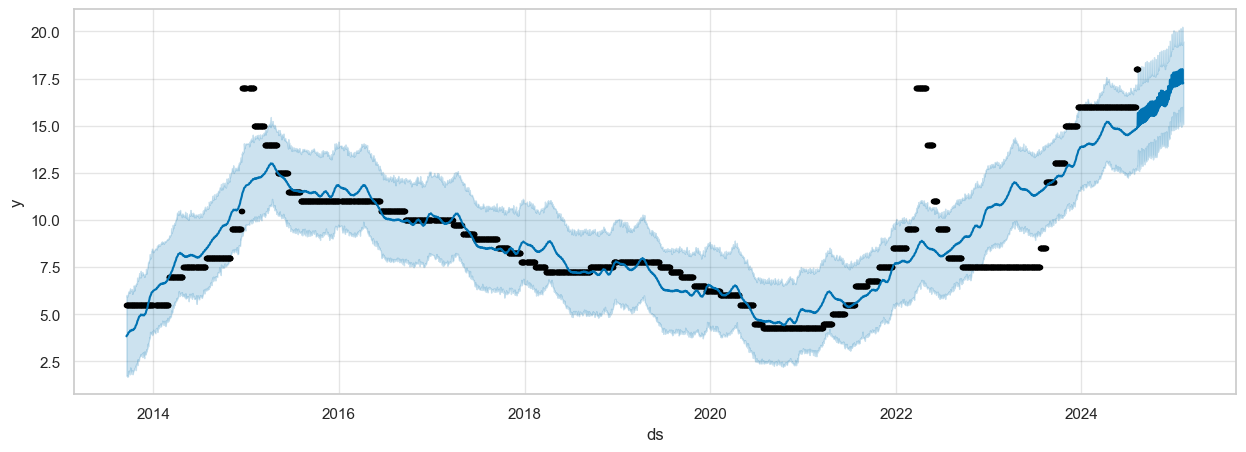

In [44]:
# Смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = prophet_bl.plot(forecast_bl,ax=ax)
plt.show()

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarn

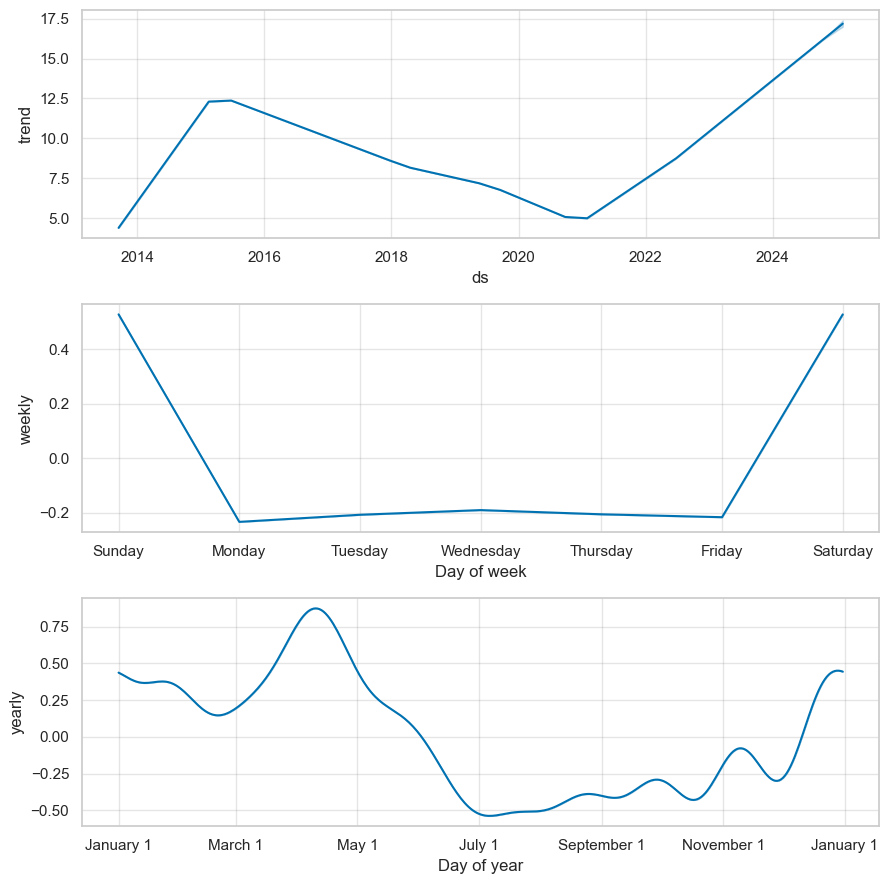

In [45]:
# Смотрим тренд, годовые и сезонные признаки
fig = prophet_bl.plot_components(forecast_bl)
plt.show()

# Prophet best params on df

In [46]:
# Обучение модели на df
final_test_model = Prophet()
final_test_model.fit(df)

00:50:24 - cmdstanpy - INFO - Chain [1] start processing
00:50:24 - cmdstanpy - INFO - Chain [1] done processing


In [47]:
# Создание df с прогнозом
future_ftm = final_test_model.make_future_dataframe(periods=pred_days_forecast, freq='D')
forecast_ftm = final_test_model.predict(future_ftm)
forecast_ftm[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2893,2025-02-01,18.001094,15.787341,20.174914
2894,2025-02-02,17.998859,15.652706,20.094943
2895,2025-02-03,17.233312,15.106819,19.349595
2896,2025-02-04,17.255561,15.020559,19.362904
2897,2025-02-05,17.268372,15.148151,19.406442


WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',



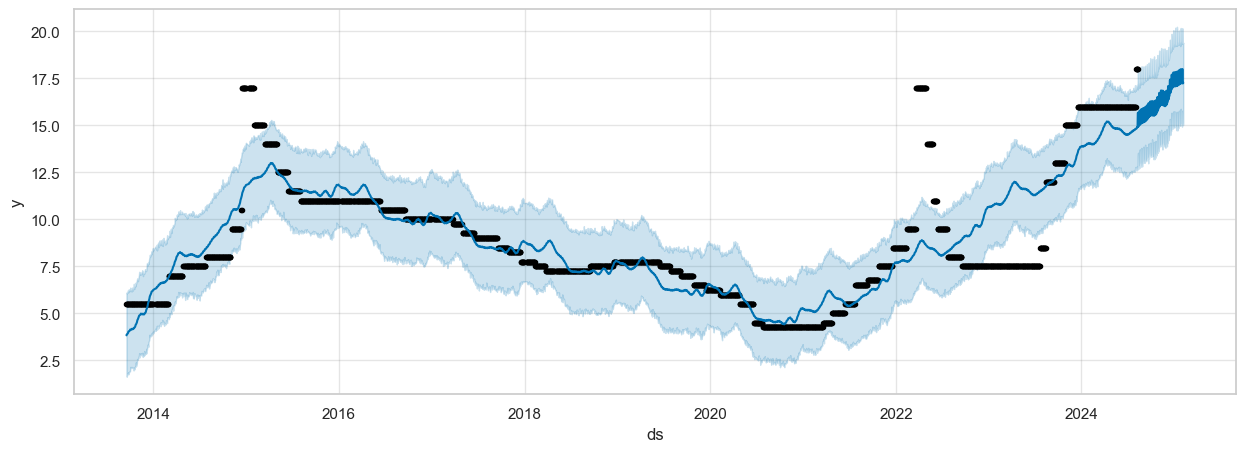

In [48]:
# Смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = final_test_model.plot(forecast_ftm,ax=ax)
plt.show()

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarn

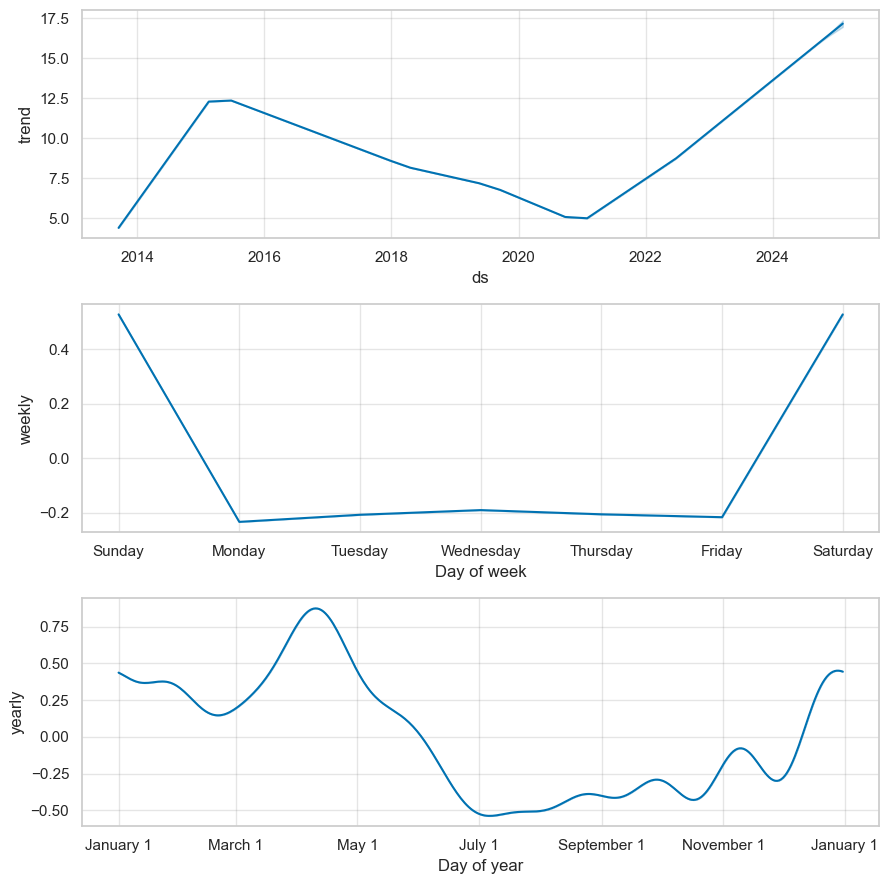

In [49]:
# Смотрим тренд, годовые и сезонные признаки
fig = prophet_bl.plot_components(forecast_ftm)
plt.show()

# NeuralProphet on df

In [50]:
# Обучение модели на df
NeuralProphet_df = NeuralProphet()
NeuralProphet_df.set_plotting_backend("plotly-static")
metricsnp = NeuralProphet_df.fit(df,)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.204% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as B
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batc

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (43) is too small than the required number                     for the learning rate finder (236). The results might not be optimal.
WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 30. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.

Finding best initial lr: 100%|██████████| 236/236 [00:01<00:00, 146.09it/s]


Training: |          | 0/? [00:25<?, ?it/s, v_num=24, train_loss=0.0264, reg_loss=0.000, MAE=0.965, RMSE=1.670, Loss=0.0263, RegLoss=0.000]


In [51]:
# Создание df с прогнозом
future_np = NeuralProphet_df.make_future_dataframe(df, periods = pred_days_forecast-104, n_historic_predictions = True)
forecast_np = NeuralProphet_df.predict(future_np)
forecast_np.tail()

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.204% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be remov

Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 199.60it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,trend,season_yearly,season_weekly
2789,2024-11-19,NaN,16.220528,16.258078,-0.034838,-0.002712
2790,2024-11-20,NaN,16.230854,16.266884,-0.032770,-0.003258
2791,2024-11-21,NaN,16.262386,16.275682,-0.030758,0.017461
2792,2024-11-22,NaN,16.255569,16.284481,-0.028751,-0.000160
2793,2024-11-25,NaN,16.289465,16.310883,-0.022596,0.001179


WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\plot_forecast_matplotlib.py:300: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst["ds"].dt.to_pydatetime()



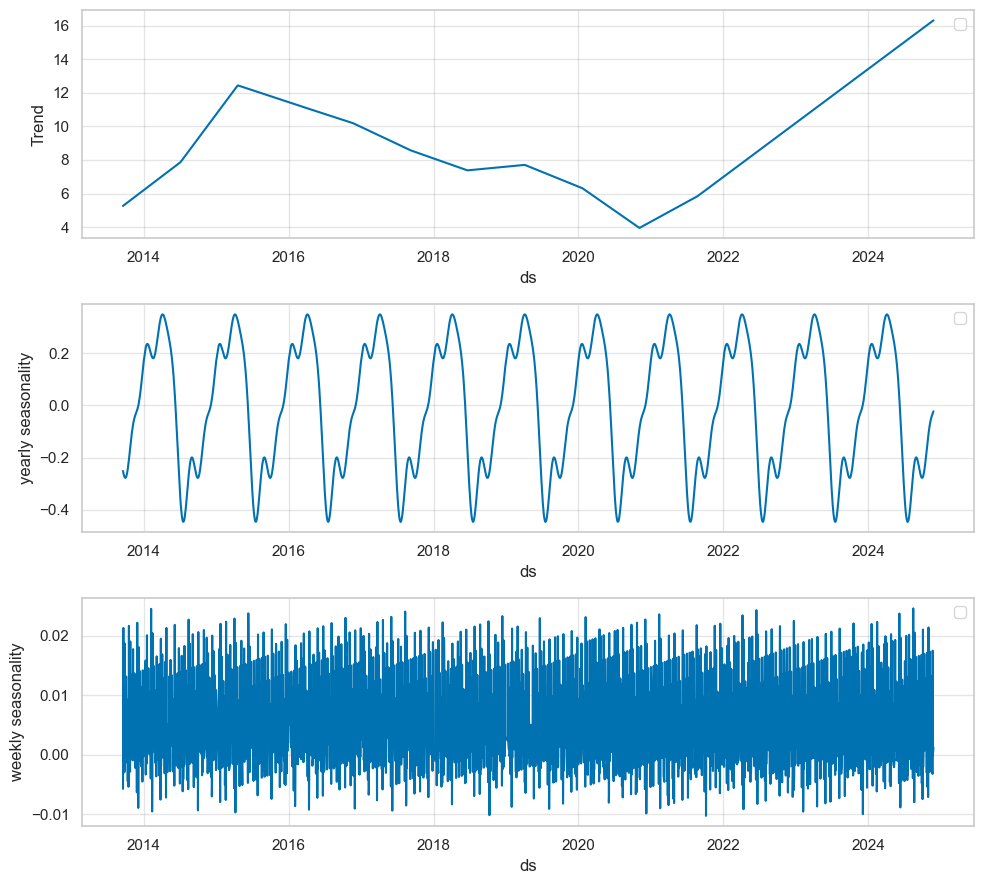

In [52]:
# Смотрим тренд, годовые и сезонные признаки
NeuralProphet_df.plot_components(forecast_np, plotting_backend="matplotlib")

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (py.warnings._showwarnmsg) - c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\plot_forecast_matplotlib.py:84: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ds = fcst["ds"].dt.to_pydatetime()



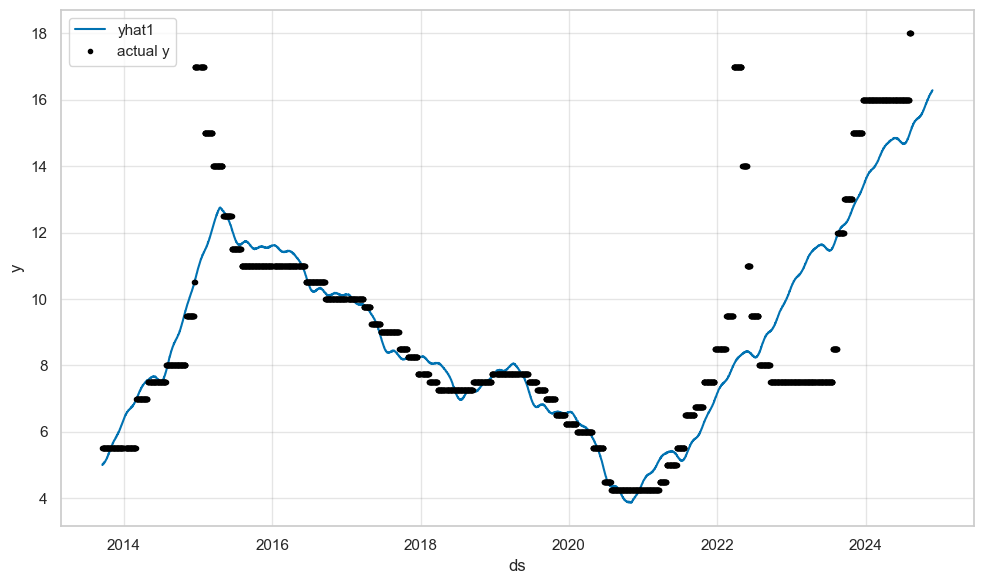

In [53]:
# Смотрим график прогноза
NeuralProphet_df.plot(forecast_np, plotting_backend="matplotlib")

# Сравнение прогнозов обученных моделей

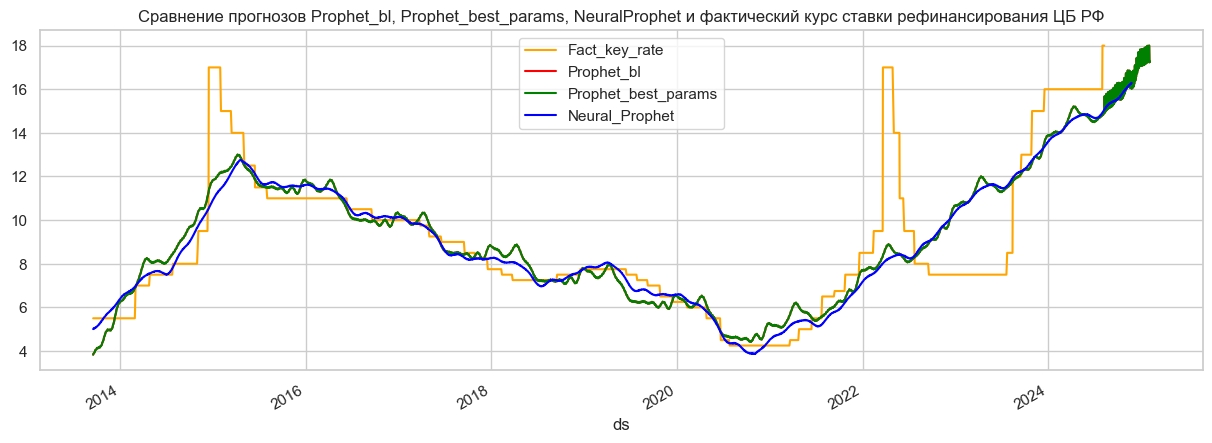

In [54]:
# Сравнение прогнозов Prophet_bl, Prophet_best_params, NeuralProphet и фактический курс ставки рефинансирования ЦБ РФ
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df.plot(kind='line',x='ds', y='y', color='orange', label='Fact_key_rate', ax=ax)
forecast_bl.plot(kind='line', x='ds', y='yhat', color='red', label='Prophet_bl', ax=ax)
forecast_ftm.plot(kind='line', x='ds', y='yhat', color='green', label='Prophet_best_params', ax=ax)
forecast_np.plot(kind='line', x='ds', y='yhat1', color='blue', label='Neural_Prophet', ax=ax)
plt.title('Сравнение прогнозов Prophet_bl, Prophet_best_params, NeuralProphet и фактический курс ставки рефинансирования ЦБ РФ')
plt.show()

Исходя из графиков, видно что Prophet с лучшими параметрами, лучше предсказал курс ключевой ставки ЦБ РФ.